In [1]:
from self_supervised_halos.utils.utils import data_preprocess_path, check_cuda
from self_supervised_halos.scripts.halo_mass_embeddings import mask_time_series_batch, RegressionModel

from self_supervised_halos.utils.dataloader import HaloDataset, img2d_transform, subhalos_df, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
%matplotlib inline

device = check_cuda()

Running on local machine
matplotlib settings set
CUDA is not available.
Device: cpu


In [2]:
dataset = HaloDataset(root_dir=data_preprocess_path,subhalos_df=subhalos_df, load_2d=False, load_3d=False, load_mass=True,)

Preparing mass data: 100%|██████████| 16544/16544 [00:18<00:00, 891.75it/s] 


In [3]:
if device=='cpu':
    batch_size = 128
else:
    print('dataloader on gpu')
    batch_size = 512

print(f'Batch size: {batch_size}')

n_data = len(dataset)
f_train = 0.6
f_val = 0.2
f_test = 1 - f_train - f_val


train_size = int(f_train*len(dataset))
val_size = int(f_val*len(dataset))
test_size = len(dataset) - train_size - val_size


trainval_ds, test_ds = torch.utils.data.random_split(dataset, [train_size+val_size, test_size])
train_size = int(f_train/(f_train+f_val)*len(trainval_ds))
val_size = len(trainval_ds) - train_size

train_ds, val_ds = torch.utils.data.random_split(trainval_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)


Batch size: 128


In [4]:
lr = 1e-3
n_epochs=10


criterion = nn.MSELoss()

model = RegressionModel(
                    optimizer_class=torch.optim.Adam,
                    optimizer_params={'lr':lr},
                    scheduler_class=torch.optim.lr_scheduler.StepLR,
                    scheduler_params={'step_size':15, 'gamma':0.5},
                    criterion=criterion,
                    history=None,
                    transform=mask_time_series_batch,
)

model.load('Regression_1d.pth')


Model HaloMassHistTransformer not found at /Users/sdbykov/work/self_supervised_halos//results/models/Regression_1d.pth


/Users/sdbykov/opt/miniconda3/envs/venv_hea/lib/python3.8/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [5]:
model.trial_forward_pass(train_loader, device)

Trial Forward Pass limit_to_first_batch=True:   0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.45891159772872925
Trial forward pass elapsed time: 0.16 s (limit_to_first_batch=True)


Trial Forward Pass:   0%|          | 0/78 [00:00<?, ?it/s]

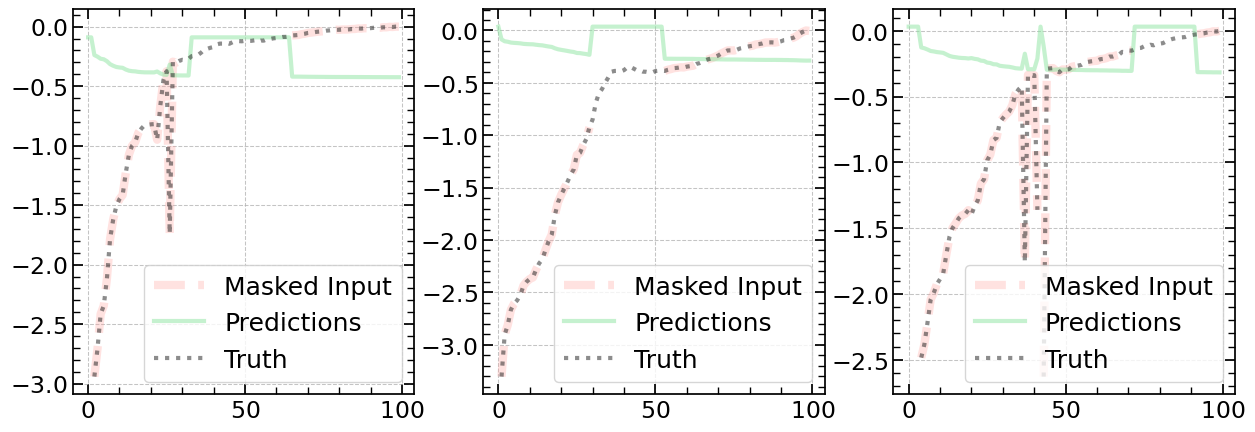

Trial Forward Pass:   0%|          | 0/78 [00:00<?, ?it/s]


In [6]:
model.show_transforms(train_loader, device)

In [7]:
model.training_loop(
    train_loader=train_loader, 
    val_loader=val_loader,
    num_epochs=n_epochs, 
    device=device)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.3038146300957753


Epochs:  10%|█         | 1/10 [00:26<03:58, 26.52s/it]

Epoch 1, Validation Loss: 0.28514214948965955
Epoch 2, Training Loss: 0.2824905594954124


Epochs:  20%|██        | 2/10 [00:50<03:18, 24.79s/it]

Epoch 2, Validation Loss: 0.2719449974023379
Epoch 3, Training Loss: 0.2756749441226323


Epochs:  30%|███       | 3/10 [01:16<02:57, 25.39s/it]

Epoch 3, Validation Loss: 0.26317767856212765
Epoch 4, Training Loss: 0.268595936970833


Epochs:  40%|████      | 4/10 [01:44<02:39, 26.63s/it]

Epoch 4, Validation Loss: 0.2597156304579515
Epoch 5, Training Loss: 0.260263024805448


Epochs:  50%|█████     | 5/10 [02:07<02:06, 25.21s/it]

Epoch 5, Validation Loss: 0.26237816306260914
Epoch 6, Training Loss: 0.25128405617597777


Epochs:  60%|██████    | 6/10 [02:32<01:40, 25.19s/it]

Epoch 6, Validation Loss: 0.24056338690794432
Epoch 7, Training Loss: 0.24770620790047523


Epochs:  70%|███████   | 7/10 [02:58<01:16, 25.45s/it]

Epoch 7, Validation Loss: 0.25736349247969115
Epoch 8, Training Loss: 0.24849640788176122


Epochs:  80%|████████  | 8/10 [03:22<00:50, 25.05s/it]

Epoch 8, Validation Loss: 0.24681090105038422
Epoch 9, Training Loss: 0.25295445284782314


Epochs:  90%|█████████ | 9/10 [03:52<00:26, 26.64s/it]

Epoch 9, Validation Loss: 0.2441746758726927
Epoch 10, Training Loss: 0.2511855279787993


Epochs: 100%|██████████| 10/10 [04:18<00:00, 25.85s/it]

Epoch 10, Validation Loss: 0.24308962661486405


In [8]:
model.save()

Model HaloMassHistTransformer saved at epoch 10


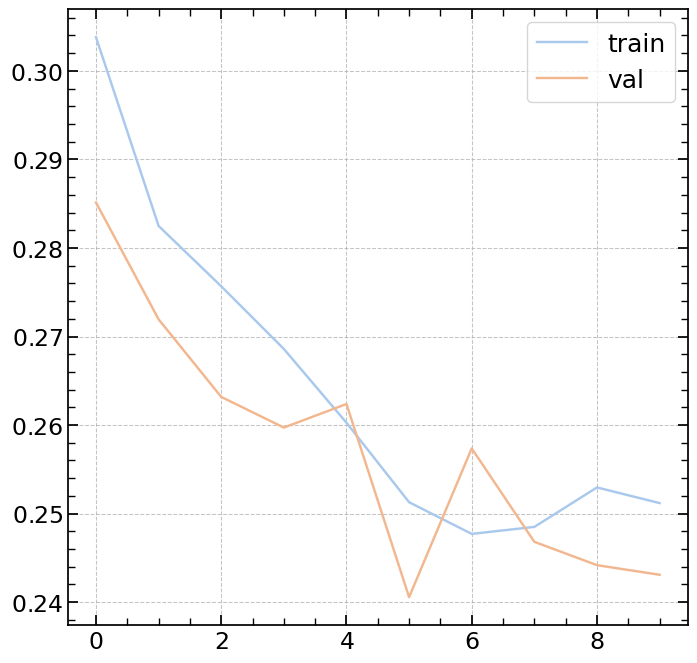

In [9]:
%matplotlib inline
plt.plot(model.history['train_loss'], label='train')
plt.plot(model.history['val_loss'], label='val')
plt.legend()
plt.show()

Trial Forward Pass:   0%|          | 0/26 [00:00<?, ?it/s]

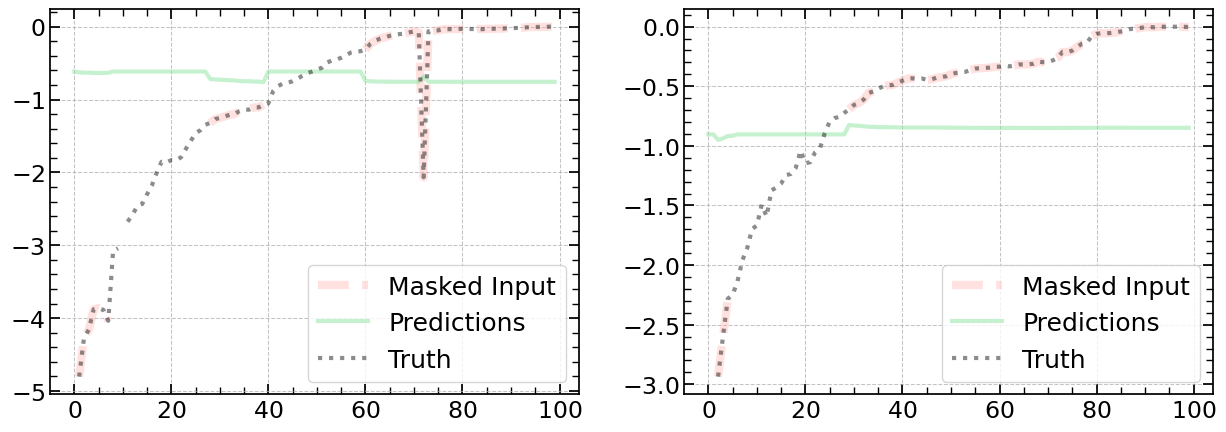

Trial Forward Pass:   0%|          | 0/26 [00:00<?, ?it/s]


In [11]:
model.show_transforms(test_loader, device)

----